In [1]:
library(Seurat)
library(Matrix)
library(dplyr)  # Ensure this is loaded for %>%
library(Azimuth)
library(scCustomize)
library(rhdf5)
library(SeuratDisk)
options(Seurat.object.assay.version = "v3") # Forziamo la versione 3 degli oggetti seurat. Conviene.
options(Seurat.object.assay.calcn = TRUE) 

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.4.1 but the current version is
4.4.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current
version is 1.7.2; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Attaching shinyBS

Warning message:
"Your system is mis-configured: '/var/db/timezone/localtime' is not a symlink"
Warning message:
"'/var/db/timezone/localtime' is not ide

In [2]:
list.files("dataset/rawdataset/")

[1] "GSE138266_RAW"                   "GSE144744"                      
[3] "GSE194078_RAW"                   "GSE194078_RAW.tar"              
[5] "gse227954_cleaned_with_meta.rds" "GSE227954_meta.csv"             
[7] "GSE227954_RAW"                   "organized_data_gse138266"       
[9] "organized_data_gse194078"

In [3]:
metadata <- read.csv("dataset/rawdataset/GSE227954_meta.csv", header = FALSE)
colnames(metadata) <- c("Barcode", "Condition", "CellType", "Tissue", "SampleID")

In [4]:
dataset_folder <- "dataset/rawdataset/GSE227954_RAW"
files_h5 <- list.files(dataset_folder, pattern = "\\.h5$", full.names = TRUE)
# Leggi ogni file e salvalo in una lista
dati_h5 <- lapply(files_h5, function(file) {

    data <- Read10X_h5(file)
    data <- CreateSeuratObject(data)

    filename <- basename(file)
    codice <- gsub(".*_(MS[0-9]+)_.*", "\\1", filename)
    tessuto <- gsub(".*_([A-Z]+)\\.h5", "\\1", filename)

    data$orig.ident <- paste0(codice, "_", tessuto)
    data$Tissue.Type <- tessuto
    data$Patient <- codice
    data$Condition <- "MS"
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = "^MT-")


    
    cat("Codice:", codice, "\nTessuto:", tessuto,"\n")
    print(data)
    data
})

Codice: MS27 
Tessuto: CSF 
An object of class Seurat 
33538 features across 657 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data
Codice: MS27 
Tessuto: PBMC 
An object of class Seurat 
33538 features across 9673 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data
Codice: MS72 
Tessuto: CSF 
An object of class Seurat 
33538 features across 483 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data
Codice: MS72 
Tessuto: PBMC 
An object of class Seurat 
33538 features across 8272 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)
 2 layers present: counts, data


In [5]:
# mergiamo tutto insieme 
merged_data <- merge(x=dati_h5[[1]], y=dati_h5[-1])
# abbiamo interesse solo nel PBMC

merged_data <- subset(merged_data, subset=Tissue.Type=="PBMC")

Warning message:
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


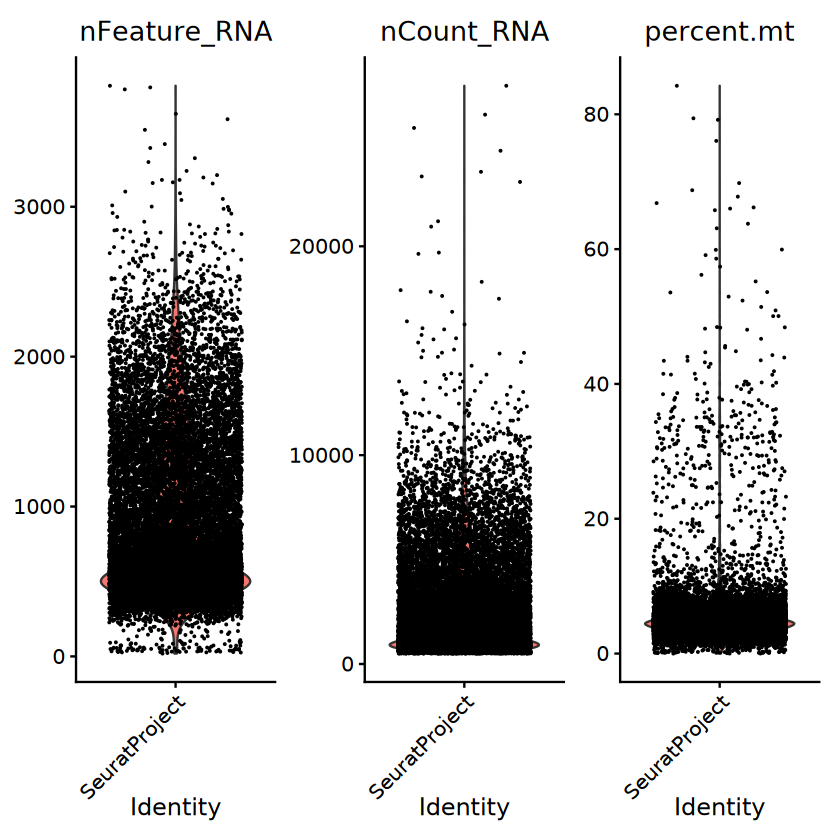

In [6]:
VlnPlot(merged_data, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

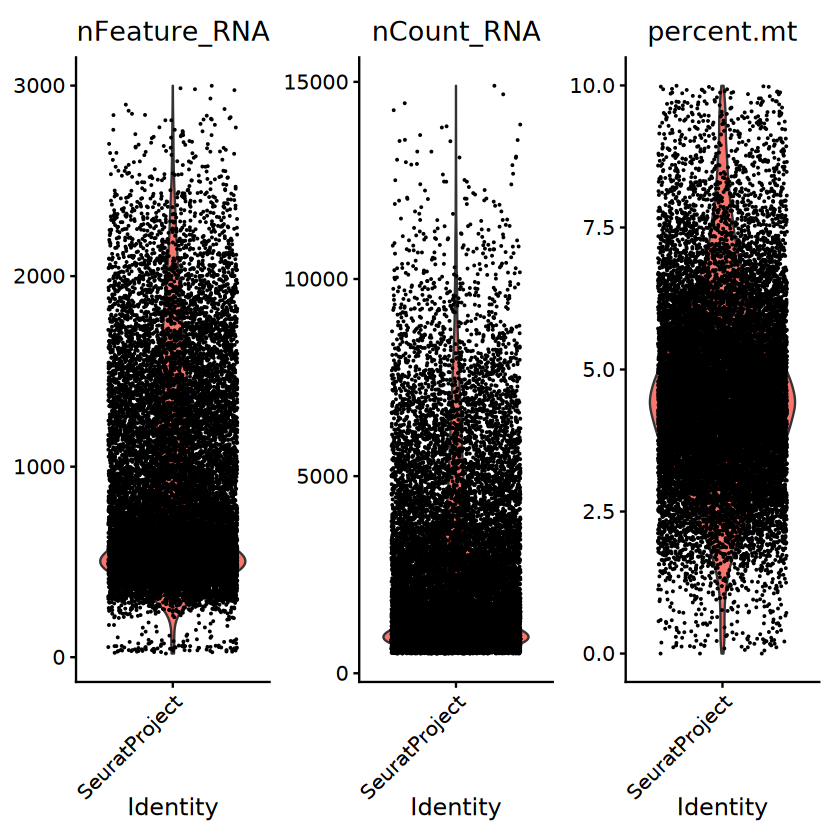

In [7]:
merged_data <- subset(merged_data, subset= nFeature_RNA < 3000 & nCount_RNA < 15000 & percent.mt <10)
VlnPlot(merged_data, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [9]:
# Facciamo girare azimuth su ognuno di questi 

merged_data <- SplitObject(merged_data, split.by='orig.ident')

# Loop through each split object and run Azimuth
for (i in seq_along(merged_data)) {
  dataset_name <- names(merged_data)[i]
  cat("Processing dataset:", dataset_name, "\n")
  
  # Run Azimuth on the current dataset
  merged_data[[i]] <- RunAzimuth(merged_data[[i]], ref = "pbmcref")
}

Processing dataset: MS27_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 2726 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

Integrating dataset 2 with reference dataset

Finding integration vecto

Processing dataset: MS72_PBMC 


Warning message:
"Overwriting miscellanous data for model"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
Warning message:
"Adding a dimensional reduction (refUMAP) without the associated assay being present"
detected inputs from HUMAN with id type Gene.name

reference rownames detected HUMAN with id type Gene.name

Normalizing query using reference SCT model

Projecting cell embeddings

Counts matrix provided is not sparse; vreating v5 assay in Seurat object

Finding query neighbors

Finding neighborhoods

Finding anchors

	Found 5634 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Predicting cell labels

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

Integrating dataset 2 with reference dataset

Finding integration vecto

In [10]:
merged_data <- merge(merged_data[[1]], y=merged_data[-1])

merged_data <- NormalizeData(merged_data)
all.genes <- rownames(merged_data)
merged_data <- ScaleData(merged_data, features = all.genes)

Centering and scaling data matrix



In [11]:
merged_data <- RunPCA(merged_data, features = all.genes)
merged_data <- RunUMAP(merged_data, dims = 1:10)

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 11743 features requested have zero variance (running reduction without them): MIR1302-2HG, FAM138A, OR4F5, AL627309.3, AL627309.2, AL627309.4, AL732372.1, OR4F29, AC114498.1, OR4F16, AL669831.2, AL645608.1, AL645608.9, LINC01342, MXRA8, AL391244.2, TMEM88B, LINC01770, VWA1, AL391845.1, AL590822.1, AL139246.4, HES5, AL831784.1, AC242022.1, AL592464.2, AL589702.1, ACTRT2, LINC00982, AL008733.1, AL590438.1, ARHGEF16, AL512413.1, AL136528.2, AL365330.1, LINC01345, LINC01777, AL355602.1, Z98747.1, LINC01646, BX005132.2, BX005132.1, AL691497.1, AL139823.1, Z98259.3, Z98259.2, Z98259.1, AL031847.1, HES3, TAS1R1, AL512330.1, Z97987.1, AL365194.1, AL359881.3, AL359881.2, AL359881.1, LINC01714, AL358876.2, SLC2A7, BX323043.1, AL928921.1, CORT, AL139423.1, MTOR-AS1, AL031291.1, NPPB, AADACL4, AADACL3, PRAMEF12, PRAMEF1, LINC01784, PRAMEF11, PRAMEF2, PRAMEF4, PRAMEF10, PRAMEF7, PRAMEF6, PRAMEF27, HNR

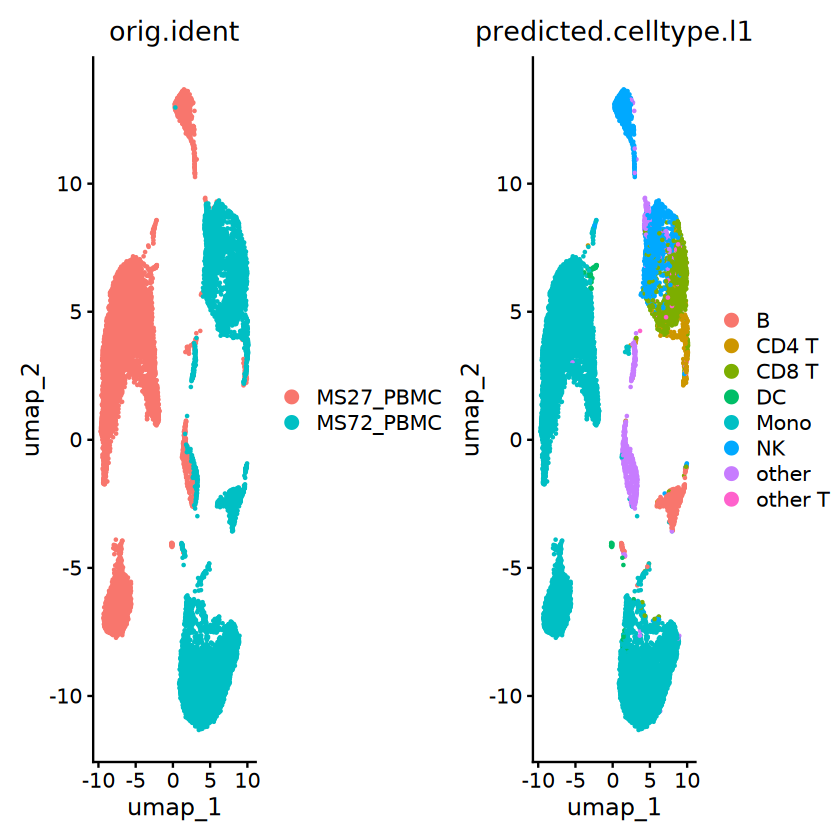

In [12]:
DimPlot(merged_data, reduction = "umap", group.by=c("orig.ident", "predicted.celltype.l1"))

In [13]:
library(Seurat)
library(SeuratDisk)

# Supponendo che `gse144744` sia un oggetto Seurat
SaveH5Seurat(merged_data, filename = "gse227954_pbmc.h5Seurat")
Convert("gse227954_pbmc.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for prediction.score.celltype.l1

Adding data for prediction.score.celltype.l1

No variable features found for prediction.score.celltype.l1

No feature-level metadata found for prediction.score.celltype.l1

Adding counts for prediction.score.celltype.l2

Adding data for prediction.score.celltype.l2

No variable features found for prediction.score.celltype.l2

No feature-level metadata found for prediction.score.celltype.l2

Adding counts for prediction.score.celltype.l3

Adding data for prediction.score.celltype.l3

No variable features found for prediction.score.celltype.l3

No feature-level metadata found for prediction.score.celltype.l3

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data 